# New York City Taxi Trip Duration
# 纽约市出租车出行时间预测

## 导包<a id="one"></a>

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb

%matplotlib inline

### 数据导入 <a id="one-a"></a>

In [61]:
df = pd.read_csv("机器学习\\纽约出租车乘车时间预测\\nyc-taxi-trip-duration\\train\\train.csv")
test = pd.read_csv("机器学习\\纽约出租车乘车时间预测\\nyc-taxi-trip-duration\\test.csv")

In [62]:
df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-3-14 17:24,2016-3-14 17:32,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-6-12 0:43,2016-6-12 0:54,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-1-19 11:35,2016-1-19 12:10,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-4-6 19:32,2016-4-6 19:39,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-3-26 13:30,2016-3-26 13:38,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [63]:
test.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-6-30 23:59,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-6-30 23:59,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-6-30 23:59,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-6-30 23:59,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-6-30 23:59,1,-73.970215,40.761475,-73.961510,40.755890,N


In [64]:
df.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  99 non-null     object 
 1   vendor_id           99 non-null     int64  
 2   pickup_datetime     99 non-null     object 
 3   dropoff_datetime    99 non-null     object 
 4   passenger_count     99 non-null     int64  
 5   pickup_longitude    99 non-null     float64
 6   pickup_latitude     99 non-null     float64
 7   dropoff_longitude   99 non-null     float64
 8   dropoff_latitude    99 non-null     float64
 9   store_and_fwd_flag  99 non-null     object 
 10  trip_duration       99 non-null     int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 8.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  ----- 

## 数据清洗 <a id="two"></a>

###  缺失值和重复值 <a id="two-a"></a>

In [65]:
df.duplicated().sum()

0

In [66]:

df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

没有缺失数据和重复数据

###  异常值的检测与处理 <a id="two-b"></a>

In [67]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,1.484848,1.424242,-73.973335,40.748455,-73.969144,40.747337,987.161616
std,0.502314,1.031058,0.040464,0.028419,0.043888,0.032165,688.956408
min,1.000000,1.000000,-74.016327,40.643558,-74.012268,40.641472,57.000000
25%,1.000000,1.000000,-73.993595,40.736208,-73.995483,40.728348,462.500000
50%,1.000000,1.000000,-73.981659,40.754070,-73.980667,40.748779,785.000000
75%,2.000000,1.000000,-73.967804,40.767286,-73.961208,40.765749,1278.500000
max,2.000000,6.000000,-73.782478,40.806606,-73.788750,40.864029,3528.000000


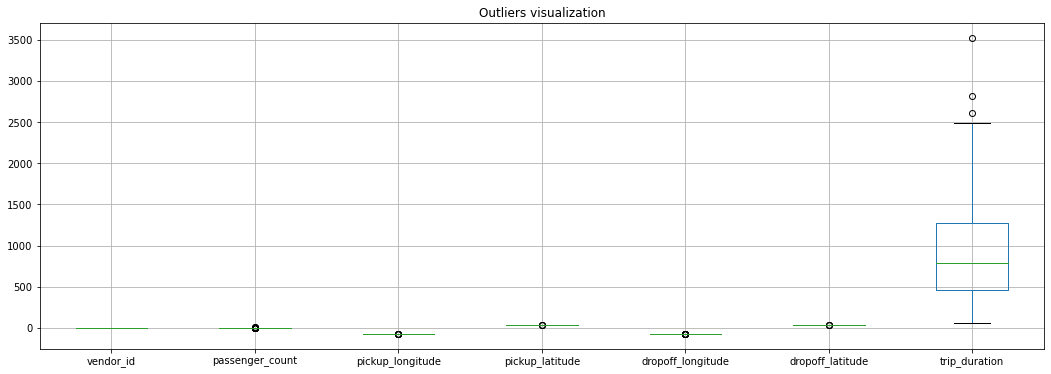

In [68]:

plt.subplots(figsize=(18,6))
plt.title("Outliers visualization")
df.boxplot();

In [69]:
df = df[(df.trip_duration < 5900)]

In [70]:
#只保留顾客人数大于1的数据
df = df[(df.passenger_count > 0)]

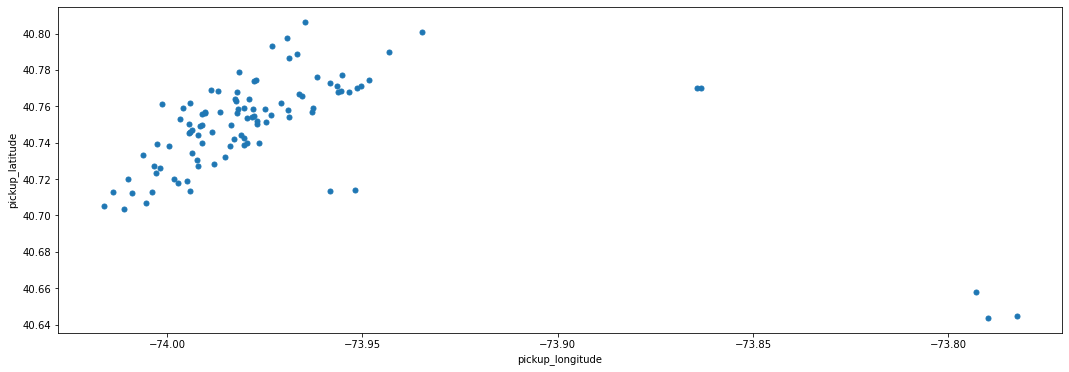

In [71]:
#去除经纬度异常的数据
pickup_longitude = list(df.pickup_longitude)
pickup_latitude = list(df.pickup_latitude)
plt.subplots(figsize=(18,6))
plt.plot(pickup_longitude, pickup_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.show()

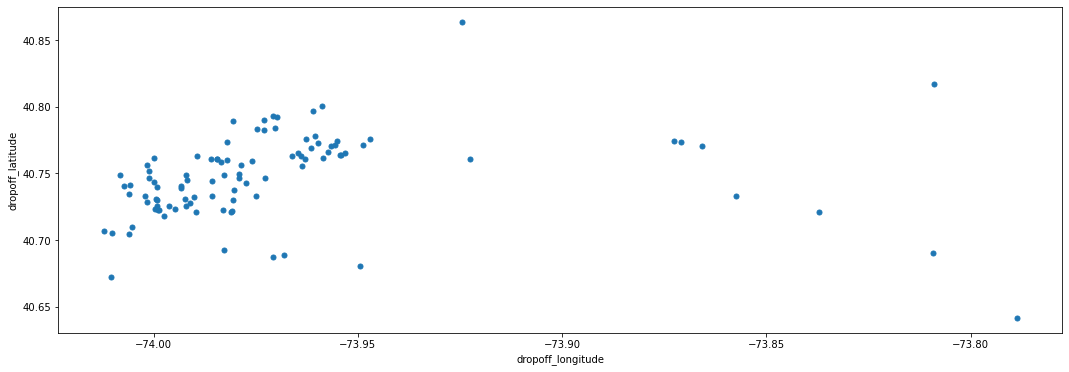

In [72]:
dropoff_longitude = list(df.dropoff_longitude)
dropoff_latitude = list(df.dropoff_latitude)
plt.subplots(figsize=(18,6))
plt.plot(dropoff_longitude, dropoff_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.show()

In [73]:
df = df[(df.pickup_longitude > -100)]
df = df[(df.pickup_latitude < 50)]


##  特征工程 <a id="three"></a>

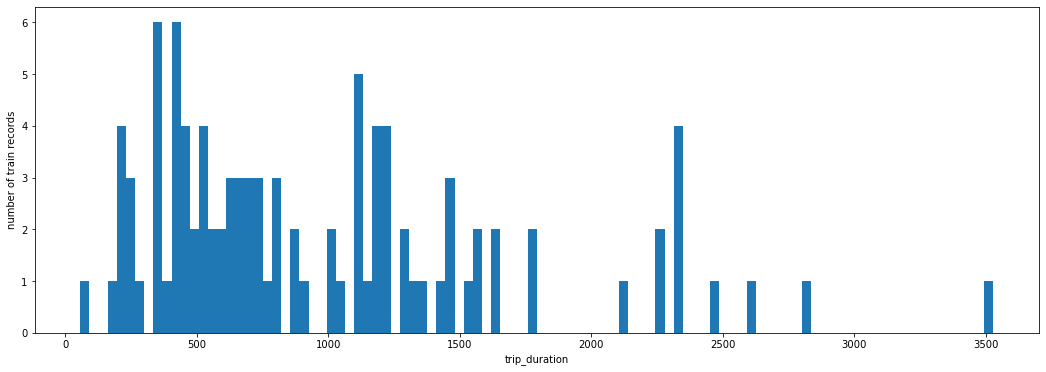

In [74]:

plt.subplots(figsize=(18,6))
plt.hist(df['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

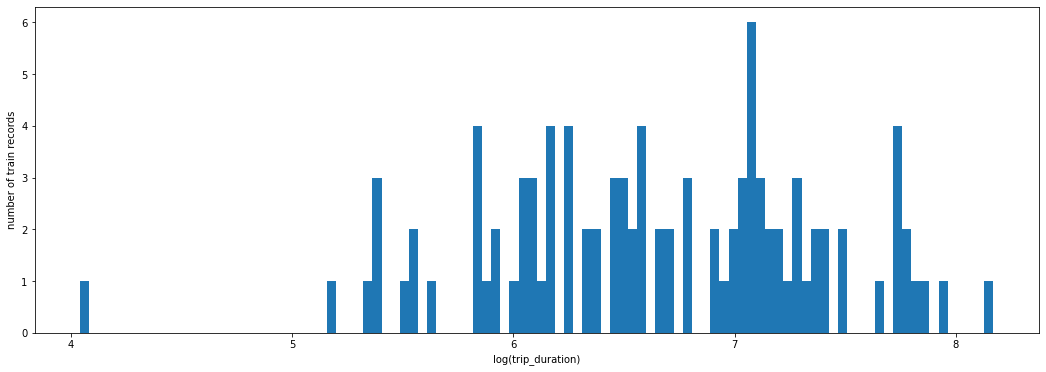

In [75]:
#Log-transformation
plt.subplots(figsize=(18,6))
df['trip_duration'] = np.log(df['trip_duration'].values)
plt.hist(df['trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

### 处理离散特征 <a id="three-b"></a>

In [76]:
df = pd.concat([df, pd.get_dummies(df['store_and_fwd_flag'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['store_and_fwd_flag'])], axis=1)

df.drop(['store_and_fwd_flag'], axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['vendor_id'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['vendor_id'])], axis=1)

df.drop(['vendor_id'], axis=1, inplace=True)

### 处理日期 <a id="three-c"></a>

In [77]:

df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

df.drop(['dropoff_datetime'], axis=1, inplace=True) #测试集中不存在这一项,直接删除，统一训练集和测试集中的数据项

#将日期中的年月日等分离出来
df['month'] = df.pickup_datetime.dt.month
df['week'] = df.pickup_datetime.dt.week
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour
df['minute'] = df.pickup_datetime.dt.minute
df['minute_oftheday'] = df['hour'] * 60 + df['minute']
df.drop(['minute'], axis=1, inplace=True)

test['month'] = test.pickup_datetime.dt.month
test['week'] = test.pickup_datetime.dt.week
test['weekday'] = test.pickup_datetime.dt.weekday
test['hour'] = test.pickup_datetime.dt.hour
test['minute'] = test.pickup_datetime.dt.minute
test['minute_oftheday'] = test['hour'] * 60 + test['minute']
test.drop(['minute'], axis=1, inplace=True)

df.drop(['pickup_datetime'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 99 non-null     object 
 1   passenger_count    99 non-null     int64  
 2   pickup_longitude   99 non-null     float64
 3   pickup_latitude    99 non-null     float64
 4   dropoff_longitude  99 non-null     float64
 5   dropoff_latitude   99 non-null     float64
 6   trip_duration      99 non-null     float64
 7   N                  99 non-null     uint8  
 8   1                  99 non-null     uint8  
 9   2                  99 non-null     uint8  
 10  month              99 non-null     int64  
 11  week               99 non-null     int64  
 12  weekday            99 non-null     int64  
 13  hour               99 non-null     int64  
 14  minute_oftheday    99 non-null     int64  
dtypes: float64(5), int64(6), object(1), uint8(3)
memory usage: 10.3+ KB


<ipython-input-77-c6ae46c2f5df>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df.pickup_datetime.dt.week
<ipython-input-77-c6ae46c2f5df>:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test['week'] = test.pickup_datetime.dt.week


### 距离和速度 <a id="three-d"></a>

In [78]:
#用于计算位置
def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

#增加距离数据项
df['distance'] = ft_haversine_distance(df['pickup_latitude'].values,
                                                 df['pickup_longitude'].values, 
                                                 df['dropoff_latitude'].values,
                                                 df['dropoff_longitude'].values)
test['distance'] = ft_haversine_distance(test['pickup_latitude'].values, 
                                                test['pickup_longitude'].values, 
                                                test['dropoff_latitude'].values, 
                                                test['dropoff_longitude'].values)

In [79]:
#用于计算方向
def ft_degree(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 #km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

#增加方向数据项
df['direction'] = ft_degree(df['pickup_latitude'].values,
                                df['pickup_longitude'].values,
                                df['dropoff_latitude'].values,
                                df['dropoff_longitude'].values)
test['direction'] = ft_degree(test['pickup_latitude'].values,
                                  test['pickup_longitude'].values, 
                                  test['dropoff_latitude'].values,
                                  test['dropoff_longitude'].values)

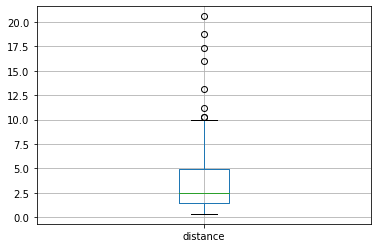

In [80]:
#查看距离的分布情况
df.boxplot(column='distance', return_type='axes');

In [81]:
#去掉距离异常值
df = df[(df.distance < 200)]

In [82]:
#将距离作为特征加入到数据集中
df['speed'] = df.distance / df.trip_duration

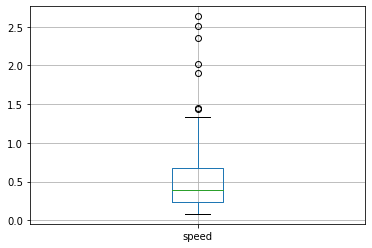

In [83]:
#V计算速度
df.boxplot(column='speed', return_type='axes');

In [84]:
df = df[(df.speed < 30)]
df.drop(['speed'], axis=1, inplace=True)

### 特征处理结果 <a id="three-e"></a>

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 99 non-null     object 
 1   passenger_count    99 non-null     int64  
 2   pickup_longitude   99 non-null     float64
 3   pickup_latitude    99 non-null     float64
 4   dropoff_longitude  99 non-null     float64
 5   dropoff_latitude   99 non-null     float64
 6   trip_duration      99 non-null     float64
 7   N                  99 non-null     uint8  
 8   1                  99 non-null     uint8  
 9   2                  99 non-null     uint8  
 10  month              99 non-null     int64  
 11  week               99 non-null     int64  
 12  weekday            99 non-null     int64  
 13  hour               99 non-null     int64  
 14  minute_oftheday    99 non-null     int64  
 15  distance           99 non-null     float64
 16  direction          99 non-nu

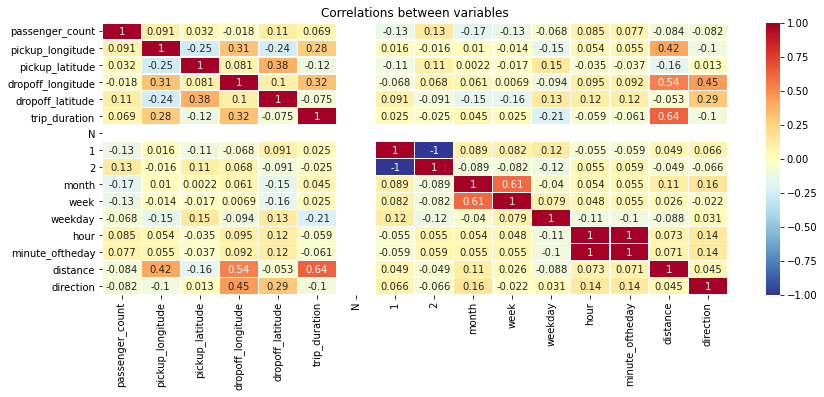

In [86]:
#联系
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(data=df.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Correlations between variables');

In [87]:
#将训练集的标签和其他属性分离出来
y = df["trip_duration"]
df.drop(["trip_duration"], axis=1, inplace=True)
df.drop(['id'], axis=1, inplace=True)
X = df

X.shape, y.shape

((99, 15), (99,))

In [88]:
#将训练数据再次分为训练集和测试集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((79, 15), (79,), (20, 15), (20,))

# 超参调参 <a id="five"></a>

In [90]:
# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 16)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

# random_cv = RandomizedSearchCV(estimator = m1, param_distributions = random_grid, n_iter = 100, cv = 3,
#                                verbose=2, random_state=42, n_jobs = -1)
# print(random_cv.best_params_)


In [91]:


lgb_params = {
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'objective': 'regression',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 }

##  模型训练和预测<a id="six"></a>

In [ ]:
lgb_df = lgb.Dataset(X, y)
lgb_model = lgb.train(lgb_params, lgb_df, num_boost_round=1500)

In [93]:
test_columns = X.columns
predictions = lgb_model.predict(test[test_columns])
submission = pd.DataFrame({'id': test.id, 'trip_duration': np.exp(predictions)})
submission.head()

,id,trip_duration
0,id3004672,1500.376396
1,id3505355,646.343989
2,id1217141,293.075758
3,id2150126,895.328672
4,id1598245,307.675633


In [95]:
#Create a csv out of the submission data frame
submission.to_csv("sub.csv", index=False)